In [1]:
## Libraries
# Standard imports
import pandas as pd
import seaborn as sns
# pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
import numpy as np
import matplotlib.pyplot as plt
import joblib
# Sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import set_config
set_config(display='diagram')

In [2]:
## Functions:

# Regression evaluator
def evaluate_regression(model,X_train,y_train,X_test,y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    
# Plots coefficients from LinearRegression model
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

# Extracts feature importances
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

# Plots feature importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [3]:
df=pd.read_csv('/Users/oliver/Desktop/datasets/sales_predictions.csv')
df = df.drop(columns = ['Item_Identifier','Outlet_Identifier','Item_Weight'])
df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# Train-test-split
y=df['Item_Outlet_Sales'].copy()
X=df.drop(columns='Item_Outlet_Sales').copy()

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42)
X_train.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,Low Fat,0.029565,Household,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,Regular,0.000000,Snack Foods,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,Regular,0.158716,Meat,157.2946,1999,Medium,Tier 1,Supermarket Type1
5327,Low Fat,0.014628,Baking Goods,82.3250,2004,Small,Tier 2,Supermarket Type1
4810,Low Fat,0.016645,Frozen Foods,120.9098,2002,NaN,Tier 2,Supermarket Type1


# Preprocessing


In [5]:
# column selectors
num_selector=make_column_selector(dtype_include='number')
cat_selector=make_column_selector(dtype_include='object')
# checking selectors
print(X_train[num_selector].info(),X_train[cat_selector].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Visibility            6392 non-null   float64
 1   Item_MRP                   6392 non-null   float64
 2   Outlet_Establishment_Year  6392 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 199.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Item_Fat_Content      6392 non-null   object
 1   Item_Type             6392 non-null   object
 2   Outlet_Size           4580 non-null   object
 3   Outlet_Location_Type  6392 non-null   object
 4   Outlet_Type           6392 non-null   object
dtypes: object(5)
memory usage: 299.6+ KB
None None


In [6]:
## Instantiating preprocessing objects
# Imputers
mean_imputer=SimpleImputer(strategy='mean')
mfrq_imputer=SimpleImputer(strategy='most_frequent')
# OneHotEncoder
ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
# Scaler
scaler=StandardScaler()

## Pipelines:
num_pipe=make_pipeline(mean_imputer,scaler)
cat_pipe=make_pipeline(mfrq_imputer,ohe)
display(num_pipe,cat_pipe)

##ColumnTransformer objects:
num_tuple=(num_pipe,num_selector)
cat_tuple=(cat_pipe,cat_selector)
preprocessor=make_column_transformer(num_tuple, cat_tuple,remainder='drop',verbose_feature_names_out=False)
preprocessor
# LP's version
# ## make the preprocessing column transformer
# preprocessor = make_column_transformer((num_pipe, num_sel),
#                                        (cat_pipe,cat_sel),                                      
#                                        verbose_feature_names_out=False)
# preprocessor

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12ed8d3a0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12ed8d9d0>)],
                  verbose_feature_names_out=False)

## Transforming data

In [7]:
X_train_processed=preprocessor.fit_transform(X_train)
X_test_processed=preprocessor.transform(X_test)

In [8]:
# Checking for nan values in transformed data
print(f'There are {np.isnan(X_train_processed).sum()} missing values in training data and {np.isnan(X_test_processed).sum()} in test data.')


There are 0 missing values in training data and 0 in test data.


In [9]:
# Getting feature names
feature_names=preprocessor.get_feature_names_out()
feature_names

array(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year',
       'Item_Fat_Content_LF', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat',
       'Item_Fat_Content_reg', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

# Remaking Our X_train and X_test as DataFrames with the New Feature Names


In [10]:
X_train_df=pd.DataFrame(X_train_processed,columns=feature_names,index=X_train.index)
X_test_df=pd.DataFrame(X_test_processed,columns=feature_names,index=X_test.index)
# putting df back together for eda
plot_train = pd.concat([X_train_df,y_train],axis=1)
plot_test = pd.concat([X_test_df,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df.head()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,Item_Type_Breads,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
4776,-0.712775,1.828109,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,515.3292
7510,-1.291052,0.603369,1.327849,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3056.0220
5828,1.813319,0.244541,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1577.9460
5327,-1.004931,-0.952591,0.732018,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1331.6000
4810,-0.965484,-0.336460,0.493686,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1687.1372


In [11]:
# Confirming first 5 rows of y_test index match X_test
y_test.head()

7503    1743.0644
2957     356.8688
7031     377.5086
1084    5778.4782
856     2356.9320
Name: Item_Outlet_Sales, dtype: float64

# LinearRegression

In [12]:
linreg=LinearRegression()
linreg.fit(X_train_df,y_train)
evaluate_regression(linreg, X_train_df,y_train,X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.45
Test Data:	R^2= 0.57	RMSE= 1092.94


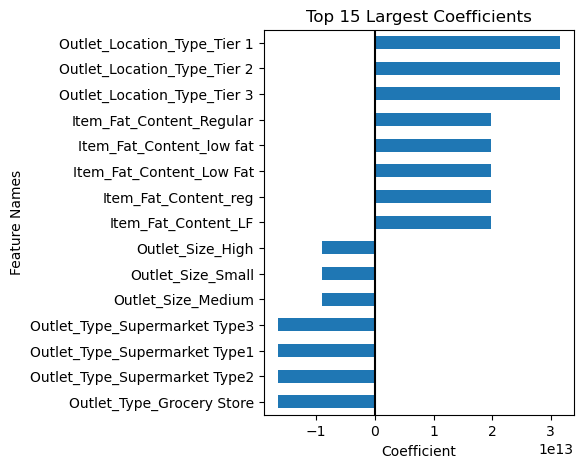

In [13]:
# Extracting coefficients
coeffs=pd.Series(linreg.coef_, index=feature_names, name='Coefficients')
# Plotting coefficients
ax= plot_coeffs(coeffs,top_n=15)
## saving plot
# ax.figure.savefig('linreg_coeffs.png')

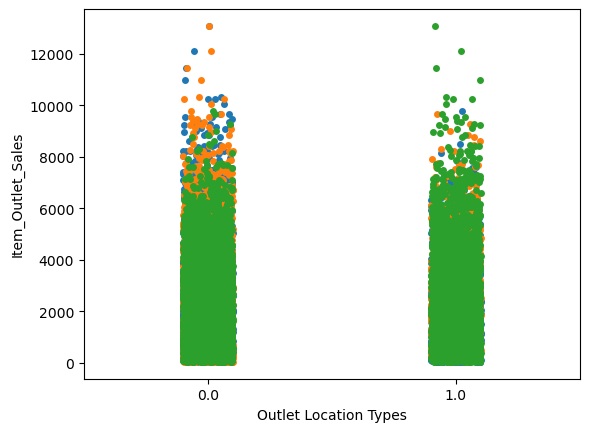

In [14]:
sns.stripplot(data=plot_df,x='Outlet_Location_Type_Tier 1',y='Item_Outlet_Sales')
sns.stripplot(data=plot_df,x='Outlet_Location_Type_Tier 2',y='Item_Outlet_Sales')
sns.stripplot(data=plot_df,x='Outlet_Location_Type_Tier 3',y='Item_Outlet_Sales')
plt.xlabel('Outlet Location Types');

- Location Type Tier 1 through 3 each have a more or less equally impactful effect on item sales.
- Item Outlet Sales and Location Types have are positively correlated.

# RandomForest

In [15]:
rf_reg=RandomForestRegressor()
rf_reg.fit(X_train_df, y_train)
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 433.19
Test Data:	R^2= 0.55	RMSE= 1109.65


Model is overfit. Needs tuning

In [16]:
# Tuning before moving on
params={'n_estimators':range(2,10), 
            'max_depth': range(2,10), 
            'max_features': ['log2', 'sqrt']
}
score=metrics.make_scorer(metrics.r2_score)
# Running grid search
grid_search=GridSearchCV(rf_reg,params,scoring=score)
grid_search.fit(X_train_df, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 10),
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': range(2, 10)},
             scoring=make_scorer(r2_score))

In [17]:
# Using estimator with best params
rf_reg=grid_search.best_estimator_
rf_reg.fit(X_train_df, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=7)

In [18]:
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.60	RMSE= 1083.15
Test Data:	R^2= 0.55	RMSE= 1109.21


After tuning, our model had more trouble learning from our data but had increased ability in predicting than the default model. Overall, our RandomForest model is just slightly better than our LinearRegression model. 

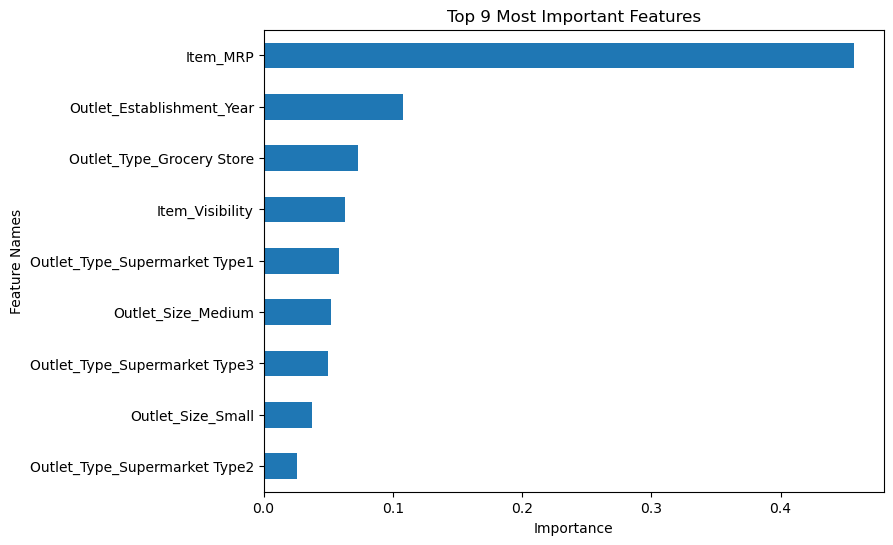

In [19]:
# Extracting and visualizing feature importances
importances= get_importances(rf_reg,sort=True, ascending=False)
# Plotting importances
ax=plot_importance(importances, top_n=9);
## Saving
# ax.figure.savefig('rf_reg_feat_importances.png')

According to our model's feature importance plot, Item_MRP has, by far, the most impact on our outcome. 
Grocery Store outlet types are the second most important with item visibility , Type 3 supermarkets, and the establishment year of the outlets following in importance. The rest of the features had much less of an impact on our prediction.

# Serializing Models with Joblib

In [20]:
# LinearRegression
lr_export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegression':linreg}
joblib.dump(lr_export, 'linreg_proj1.joblib')

['linreg_proj1.joblib']

In [21]:
# RandomForest
rf_export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':rf_reg}
joblib.dump(rf_export, 'rf_reg_proj1.joblib')

['rf_reg_proj1.joblib']